<a href="https://colab.research.google.com/github/tjohanne42/time_series_project_simplon/blob/main/time_series_theo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tjohanne42/time_series_project_simplon.git
!pip install darts
!pip install keras-tcn

fatal: destination path 'time_series_project_simplon' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math
import copy

from time_series_project_simplon.utils.functions import generate_df_by_time_section
from time_series_project_simplon.utils import functions

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.metrics import mape, mase, mae, mse, ope, rmse, rmsle
from darts.metrics import r2_score as darts_r2_score
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset 
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from tcn import TCN

# I. Load data

In [3]:
# dir(functions)

In [4]:
df_raw = generate_df_by_time_section(time_section="day", verbose=True)
df_raw.tail()

replace outliers in 'solar' values with interpolation ...
set seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean values for every day ...
multiply all values by 12 * 24 to get the actual values by day ...
done


,timestamp,coal,nuclear,wind,hydro,solar
2767,2019-07-30,0.0,1.573999e+06,1.233718e+06,73637.000000,376435.335097
2768,2019-07-31,0.0,1.606865e+06,1.685585e+06,92945.000000,355390.763997
2769,2019-08-01,0.0,1.606940e+06,6.505120e+05,117124.000000,519328.582901
2770,2019-08-02,0.0,1.592180e+06,2.959050e+05,115334.000000,596295.099905
2771,2019-08-03,0.0,1.567348e+06,1.844990e+05,90230.518519,607272.596147


# II. Darts for the men, Darts for the girls

In [ ]:
col = "wind"
time_col = "timestamp"
df_for_darts = copy.deepcopy(df_raw)

In [ ]:
# "solar"
# for i in df_for_darts.index:
#   if df_for_darts["solar"][i] > 0.0:
#     break
# df_for_darts = df_for_darts.iloc[i+1:]
# df_for_darts.reset_index(drop=True, inplace=True)
# df_for_darts["solar"][df_for_darts["solar"] <= 0.0] = 0.1
# df_for_darts[df_for_darts["solar"] <= 0.0]

In [ ]:
series = df_for_darts[col]
series.index = df_for_darts[time_col]
series = pd.DataFrame(series)
print("size null values:", len(series[series[col] == 0.0]))
series = TimeSeries.from_dataframe(series)

size null values: 0


In [ ]:
# seasonality
ALPHA = 0.05

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? True
There is seasonality of order 9.


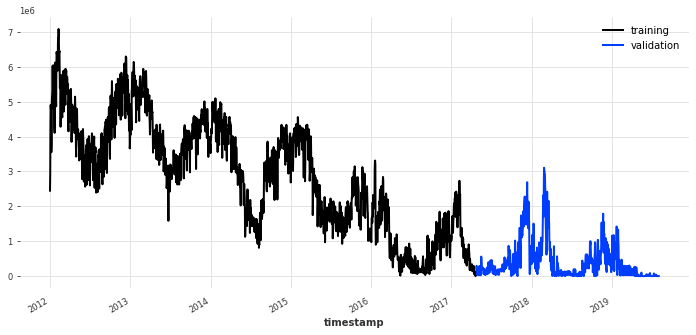

In [ ]:
# train_test_split
val_size = 0.3
split_at = pd.Timestamp(df_for_darts[time_col][len(df_for_darts) - int(val_size * len(df_for_darts))])

train, val = series.split_before(split_at)

plt.figure(figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [ ]:
# # prepare ARIMA forecaster

# y = np.asarray(series.pd_series())
# # get order of first differencing: the higher of KPSS and ADF test results
# n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
# n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
# n_diff = max(n_adf, n_kpss)

# # get order of seasonal differencing: the higher of OCSB and CH test results
# n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
# n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
# ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# # set up the ARIMA forecaster
# m_arima = AutoARIMA(
#     start_p=1, d=n_diff, start_q=1,
#     max_p=4, max_d=n_diff, max_q=4,
#     start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
#     max_P=3, max_D=1, max_Q=3,
#     max_order=5,                       # p+q+p+Q <= max_order
#     stationary=False, 
#     information_criterion="bic", alpha=ALPHA, 
#     test="kpss", seasonal_test="ocsb",
#     stepwise=True, 
#     suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")

In [ ]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    # res_mape = mape(val, pred_theta)
    res_mape = rmsle(val, pred_theta)
    # res_mape = mean_absolute_percentage_error(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100

[2021-10-19 15:25:40,453] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
[2021-10-19 15:25:40,453] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.7/dist-packages/darts/metrics/metrics.py:398: RuntimeWarning:

invalid value encountered in log

[2021-10-19 15:25:40,503] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
[2021-10-19 15:25:40,503] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.7/dist-packages/darts/metrics/metrics.py:398: RuntimeWarning:



In [ ]:
if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()
m_naive = NaiveDrift()
m_prophet = Prophet()

In [ ]:
def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))
    
    # print(forecast.values())
    

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()

    true = val.values()
    # true = [max(x, 0.0) for x in true]
    pred = forecast.values()
    # compute accuracy metrics and processing time
    res_mape = mean_absolute_percentage_error(true, pred)
    res_mae = mean_absolute_error(true, pred)
    res_r2 = r2_score(true, pred)
    res_mse = mean_squared_error(true, pred)
    res_rmse = np.sqrt(mean_squared_error(true, pred))
    res_rmsle = np.log(np.sqrt(mean_squared_error(true, pred)))

    try:
      res_darts_mape = mape(val, forecast)
    except:
      res_darts_mape = None
    res_darts_mae = mae(val, forecast)
    res_darts_r2 = darts_r2_score(val, forecast)
    res_darts_rmse = rmse(val, forecast)
    res_darts_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE": res_mape, "MAE": res_mae, "R squared": -res_r2, "MSE": res_mse, "RMSE": res_rmse, "RMSLE" :res_rmsle, "time": res_time,
                    "DARTS_MAPE": res_darts_mape, "DARTS_MAE": res_darts_mae, "DARTS_R squared": res_darts_r2, "DARTS_RMSE": res_darts_rmse,
                    "DARTS_RMSLE": res_darts_rmsle}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

models = {"prophet": m_prophet, "naive": m_naive, "expon": m_expon, "theta": m_theta}

model_predictions = [eval_model(v) for k, v in models.items()]
model_predictions

beginning: Prophet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[2021-10-19 15:25:51,431] ERROR | darts.metrics.metrics | ValueError: The actual series must be strictly positive to compute the MAPE.
ERROR:darts.metrics.metrics:ValueError: The actual series must be strictly positive to compute the MAPE.
/usr/local/lib/python3.7/dist-packages/darts/metrics/metrics.py:398: RuntimeWarning:

invalid value encountered in log

[2021-10-19 15:25:51,510] ERROR | darts.metrics.metrics | ValueError: The actual series must be strictly positive to compute the MAPE.
ERROR:darts.metrics.metrics:ValueError: The actual series must be strictly positive to compute the MAPE.
/usr/local/lib/python3.7/dist-packages/darts/metrics/metrics.py:398: RuntimeWarning:

invalid value encountered in log



completed: Prophet:5.718989820999923sec
beginning: Naive drift model
completed: Naive drift model:0.07673737699997218sec
beginning: Exponential smoothing


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

[2021-10-19 15:25:52,005] ERROR | darts.metrics.metrics | ValueError: The actual series must be strictly positive to compute the MAPE.
ERROR:darts.metrics.metrics:ValueError: The actual series must be strictly positive to compute the MAPE.
/usr/local/lib/python3.7/dist-packages/darts/metrics/metrics.py:398: RuntimeWarning:

invalid value encountered in log

[2021-10-19 15:25:52,065] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
[2021-10-19 15:25:52,065] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 7
INFO:darts.models.forecasting.theta:Theta model inferred seasonality of training series: 7
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals

completed: Exponential smoothing:0.4951590219998252sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.11307857599990712sec


[[<TimeSeries (DataArray) (time: 831, component: 1, sample: 1)>
  array([[[ 2.41184957e+05]],
  
         [[ 2.34336837e+05]],
  
         [[ 2.11775063e+05]],
  
         [[ 1.24978387e+05]],
  
         [[-3.00953565e+05]],
  
         [[-4.17849765e+05]],
  
         [[ 2.50471548e+04]],
  
         [[ 1.00167953e+05]],
  
         [[ 8.68834862e+04]],
  
         [[ 5.82239807e+04]],
  
  ...
  
         [[-2.27043594e+06]],
  
         [[-2.35459999e+06]],
  
         [[-2.77563831e+06]],
  
         [[-2.88513662e+06]],
  
         [[-2.43216785e+06]],
  
         [[-2.34420696e+06]],
  
         [[-2.34186398e+06]],
  
         [[-2.35216212e+06]],
  
         [[-2.42350775e+06]],
  
         [[-2.83076654e+06]]])
  Coordinates:
    * time       (time) datetime64[ns] 2017-04-25 2017-04-26 ... 2019-08-03
    * component  (component) object 'coal'
  Dimensions without coordinates: sample,
  {'MAPE': 8.706726977888314e+20,
   'MAE': 1099206.0176952872,
   'R squared': 4.36320170349

In [ ]:
df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")

for i, m in enumerate(models):
    if i > 0:
        df_tmp = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df_tmp.columns = [str(m)]
        df_acc = pd.concat([df_acc, df_tmp], axis=1)
    i +=1

df_acc.columns = models.keys()
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1549: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1547: RuntimeWarning:

All-NaN slice encountered



,prophet,naive,expon,theta
MAPE,870672697788831367168.000,348150364493067583488.000,3641753062012556935168.000,151622925839901491200.000
MAE,1099206.018,857353.612,5124934.473,368447.760
R squared,4.363,2.497,110.598,0.156
MSE,1621314977029.230,1057280772279.488,33736604381227.027,349544401664.404
RMSE,1273308.673,1028241.592,5808321.994,591222.802
RMSLE,14.057,13.843,15.575,13.290
time,5.719,0.077,0.495,0.113
DARTS_MAPE,nan,nan,nan,nan
DARTS_MAE,1099206.018,857353.612,5124934.473,368447.760
DARTS_R squared,-4.363,-2.497,-110.598,-0.156


_______________________coal_______________________


/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1549: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1547: RuntimeWarning:

All-NaN slice encountered



,prophet,naive,expon,theta
MAPE,870672697788831367168.000,348150364493067583488.000,3641753062012556935168.000,151622925839901491200.000
MAE,1099206.018,857353.612,5124934.473,368447.760
R squared,4.363,2.497,110.598,0.156
MSE,1621314977029.230,1057280772279.488,33736604381227.027,349544401664.404
RMSE,1273308.673,1028241.592,5808321.994,591222.802
RMSLE,14.057,13.843,15.575,13.290
time,5.719,0.077,0.495,0.113
DARTS_MAPE,nan,nan,nan,nan
DARTS_MAE,1099206.018,857353.612,5124934.473,368447.760
DARTS_R squared,-4.363,-2.497,-110.598,-0.156


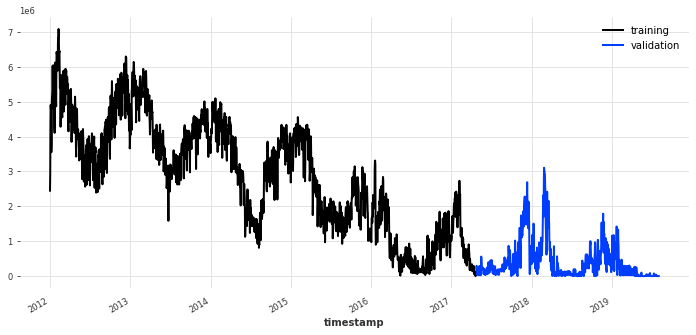

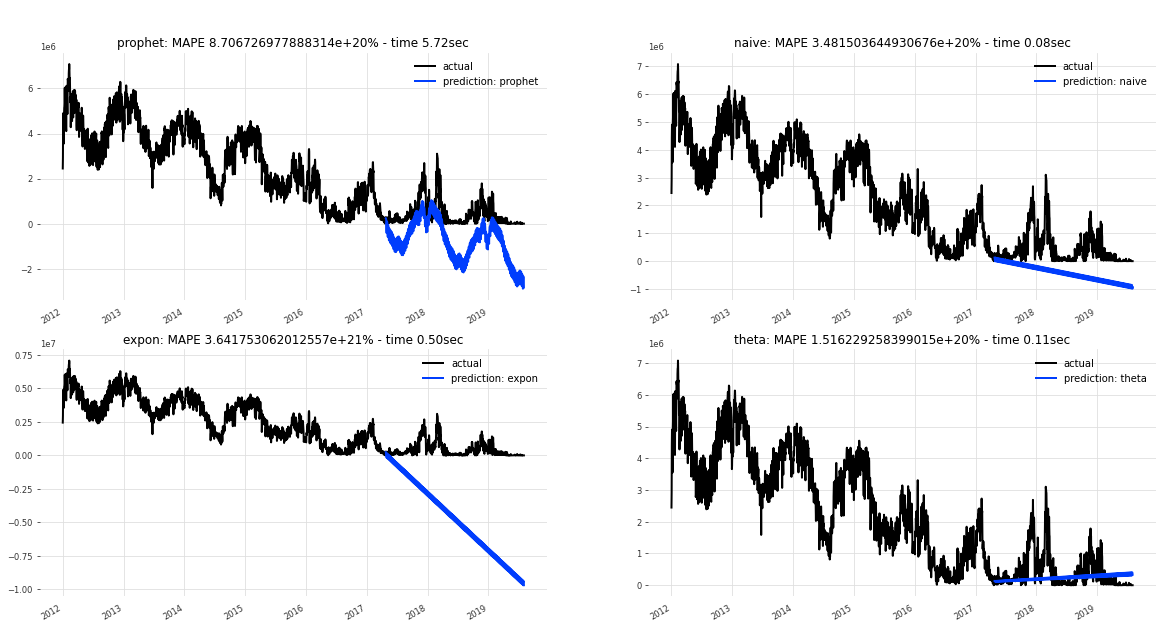

In [ ]:
print(col.center(50, "_"))

plt.figure(figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
      series.plot(label="actual", ax=ax[i])
      model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
      
      mape_model =  model_predictions[i][1]["MAPE"]
      time_model =  model_predictions[i][1]["time"]
      ax[i].set_title("\n\n" + str(m) + f": MAPE {str(mape_model)}%" + " - time {:.2f}sec".format(time_model))

      ax[i].set_xlabel("")
      ax[i].legend()
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

# II. Train & Pred

In [24]:
from math import sqrt
import os
from tqdm import tqdm

import keras
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tqdm.keras import TqdmCallback

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
col = "nuclear"

print(df_raw.shape)
display(df_raw.head())
df_raw.info()

(2772, 6)


,timestamp,coal,nuclear,wind,hydro,solar
0,2012-01-01,2.448325e+06,2.029537e+06,760388.000000,226484.000000,0.0
1,2012-01-02,2.938653e+06,2.037884e+06,795531.261324,224000.780488,0.0
2,2012-01-03,4.430877e+06,2.005847e+06,621916.000000,231623.000000,0.0
3,2012-01-04,4.903744e+06,2.039013e+06,764407.000000,232221.000000,0.0
4,2012-01-05,4.765032e+06,2.171748e+06,760181.000000,238301.000000,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 0 to 2771
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2772 non-null   datetime64[ns]
 1   coal       2772 non-null   float64       
 2   nuclear    2772 non-null   float64       
 3   wind       2772 non-null   float64       
 4   hydro      2772 non-null   float64       
 5   solar      2772 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 151.6 KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4315: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



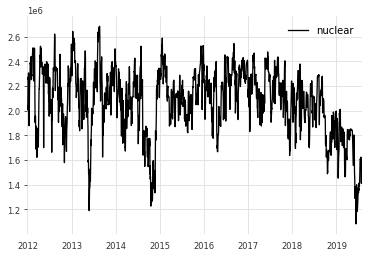

,nuclear
2012-01-01,2.029537e+06
2012-01-02,2.037884e+06
2012-01-03,2.005847e+06
2012-01-04,2.039013e+06
2012-01-05,2.171748e+06


In [26]:
df = df_raw[["timestamp", col]]
df.set_index(df["timestamp"].values, drop=True, inplace=True)
df.drop("timestamp", axis=1, inplace=True)
df.plot()
plt.show()
df.head()

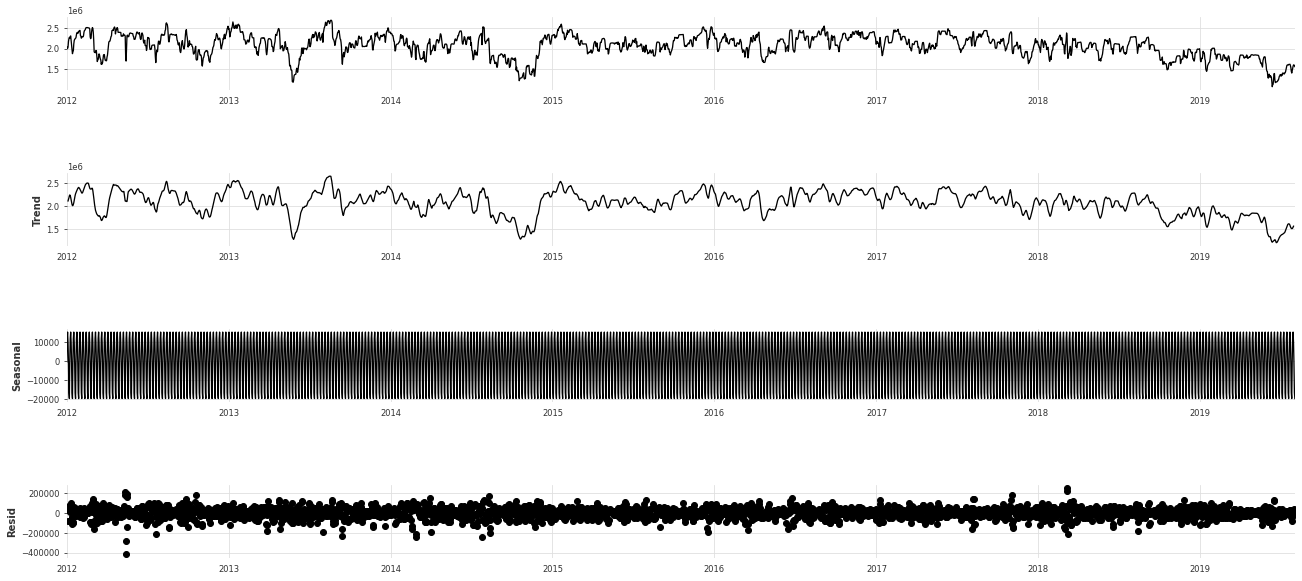

In [27]:
decomposition = seasonal_decompose(df)
fig = decomposition.plot();
fig.set_size_inches(21, 9)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



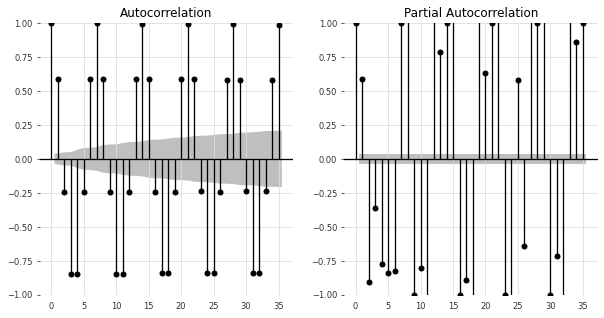

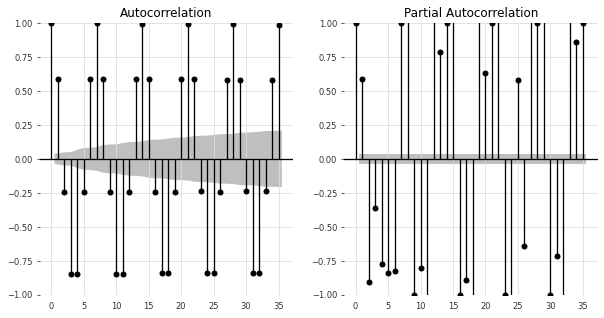

In [28]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plot_acf(decomposition.seasonal, ax=ax[0])
plot_pacf(decomposition.seasonal, ax=ax[1])

In [29]:
# Divide data into train and test sets
train_split_percent = 0.75

train_split_percent = int(df.shape[0] * train_split_percent)

train = df.iloc[:train_split_percent]
test = df.iloc[train_split_percent:]

In [30]:
# Normalize training data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
 
# Create supervised data with 12 inputs and 1 output
n_lag = 30
n_output = 30
X_train = []
y_train = []
for i in range(n_lag, len(train) - n_lag):
    X_train.append(train_scaled[i-n_lag:i, 0])
    y_train.append(train_scaled[i:i+n_output, 0])
 
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Reshape train set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 30)            60        
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 256)           293888    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
output (Dense)               (None, 30)                1950      
Total params: 542,426
Trainable params: 542,426
Non-trainable params: 0
_____________________________________________________

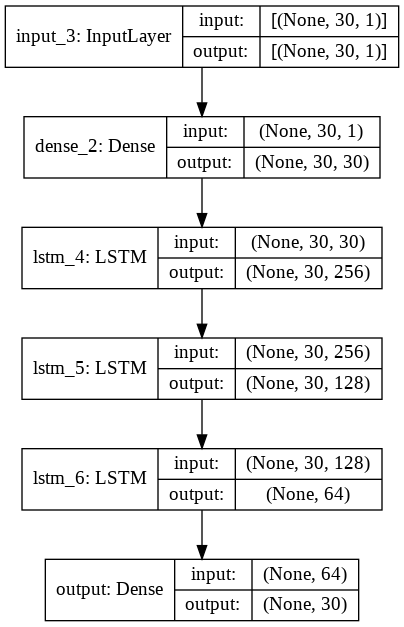

In [31]:
inputs = Input(shape=(X_train.shape[1], 1))

main = Dense(n_lag, activation="relu")(inputs)

main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
# main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
# main = LSTM(64, activation="tanh", recurrent_activation="sigmoid")(main)
# main = LSTM(128, activation="tanh", recurrent_activation="sigmoid")(main)
# main = TCN()(main)
main = LSTM(64, activation="tanh", recurrent_activation="sigmoid")(main)

main = Dense(n_output, activation=None, name='output')(main)

model = Model(inputs, main)

model.summary()

model.compile(
  optimizer = Adam(learning_rate=0.001),
  loss = "mae",
)
plot_model(model, to_file="blbl.png", show_shapes=True)

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

  0%|          | 0.00/101 [00:00<?, ?batch/s]

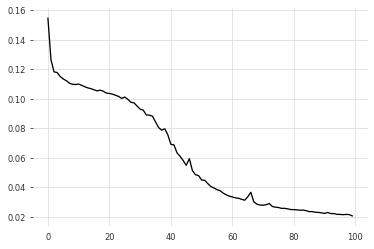

In [32]:
if not os.path.isdir("model"):
  os.system("mkdir model")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model/model.h5",
    mode='max',
    save_best_only=True)

history = model.fit(
      X_train,
      y_train,
      validation_split=0.2,
      epochs=100,
      verbose=0,
      batch_size=16,
      callbacks=[model_checkpoint_callback, TqdmCallback(verbose=2)]
  )

# show loss
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.show()

## b) predict

In [39]:
predict = pd.DataFrame(test.values)
predict.columns = [col]
predict.index = test.index
predict

,nuclear
2017-09-10,2.293252e+06
2017-09-11,2.293627e+06
2017-09-12,2.185045e+06
2017-09-13,2.151942e+06
2017-09-14,2.139938e+06
...,...
2019-07-30,1.573999e+06
2019-07-31,1.606865e+06
2019-08-01,1.606940e+06
2019-08-02,1.592180e+06


pred_t+1_from_true_values

In [40]:
inputs = df[len(df) - len(test) - n_lag:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(n_lag, n_lag+len(test)):
    X_test.append(inputs[i-n_lag:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 
# Forecast
predict_scaled = model.predict(X_test)
pred_tab = []
for tmp in predict_scaled:
  if n_output > 1:
    pred_tab.append(tmp[0])
  else:
    pred_tab.append(tmp)
predict_scaled = sc.inverse_transform(np.reshape(pred_tab, (-1, 1)))

predict['pred_t+1_from_true_values'] = predict_scaled

pred n_lag by n_lag

In [41]:
test_predictions = []
first_batch_for_prediction = train_scaled[-n_lag :]
current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))
print(current_batch.shape)
for index in tqdm(range(0, len(predict), n_output)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions += list(current_prediction)
    # current_batch = current_prediction.reshape((1, n_lag, 1))
    if n_lag > n_output:
        n_elements_to_keep = n_lag - n_output
        current_batch[0, :n_elements_to_keep, 0] = current_batch[0, -n_elements_to_keep:, 0]
        current_batch[0, -n_elements_to_keep:, 0] = current_prediction
    else:
        current_batch = current_prediction[-n_lag:].reshape((1, n_lag, 1))
test_predictions = np.array(test_predictions).reshape((-1, 1))
test_predictions_unnormalized = sc.inverse_transform(test_predictions)
predict["pred n_lag by n_lag"] = test_predictions_unnormalized[:len(predict)]

(1, 30, 1)


100%|██████████| 24/24 [00:01<00:00, 16.47it/s]


In [42]:
# test_predictions = []
# first_batch_for_prediction = train_scaled[-n_lag :]
# current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))

# for index in tqdm(range(0, len(test), n_lag)):

#   current_prediction = model.predict(current_batch)[0]

#   test_predictions += list(current_prediction)

#   current_batch = current_prediction.reshape((1, n_lag, 1))

# test_predictions_unnormalized = sc.inverse_transform(np.reshape(test_predictions, (-1, 1)))

# predict["pred n_lag by n_lag"] = test_predictions_unnormalized[:predict.shape[0]]

pred 1 by 1

100%|██████████| 693/693 [00:40<00:00, 17.06it/s]


<AxesSubplot:>

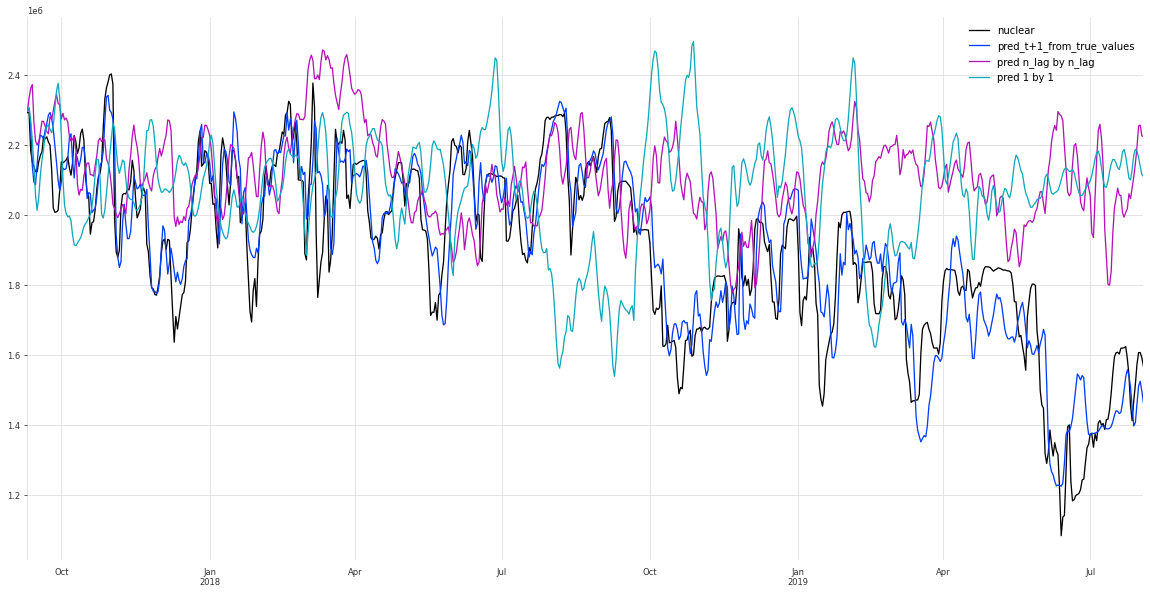

In [37]:
test_predictions = []
first_batch_for_prediction = train_scaled[-n_lag :]
current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))

for index in tqdm(range(0, len(test))):

  current_prediction = model.predict(current_batch)[0][0]

  test_predictions.append(current_prediction)

  current_batch = np.append(current_batch[:, 1:, :], [[[current_prediction]]], axis=1)


test_predictions_unnormalized = sc.inverse_transform(np.reshape(test_predictions, (-1, 1)))

predict["pred 1 by 1"] = test_predictions_unnormalized[:predict.shape[0]]
predict.plot(figsize=(20,10))

## b) Metrics

In [38]:
for tmp_col in predict.columns:
  if "pred" in tmp_col:
    print("col name:", tmp_col)

    rmse = sqrt(mean_squared_error(predict[col], predict[tmp_col]))
    print("rmse:", rmse)

col name: pred_t+1_from_true_values
rmse: 108583.34919930258
col name: pred n_lag by n_lag
rmse: 342837.8128925422
col name: pred 1 by 1
rmse: 370264.4086096585
